In [2]:
from typing import Literal, Optional, Union

import csv
import math
import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm

import matplotlib.pyplot as plt


class gergen:
    pass


######################################################################
#--------------------------- TYPE ALIASES ---------------------------#
######################################################################

DistributionType = Literal['uniform', 'normal']
ActivationType = Literal['softmax', 'relu']

MNISTSampleType = tuple[int, list[int]]
"""
The first element is the label of the image, and the second element is the pixel values of the image.
"""
MNISTDataType = list[MNISTSampleType]

Atomic = Union[int, float]
ListOrAtomic = Union[list, Atomic]
GergenOrAtomic = Union['gergen', Atomic]

isAtomic = lambda obj: isinstance(obj, (int, float))
isList = lambda obj: isinstance(obj, list)
isTuple = lambda obj: isinstance(obj, tuple)
isGergen = lambda obj: isinstance(obj, gergen)
isListOrAtomic = lambda obj: isList(obj) or isAtomic(obj)
isGergenOrAtomic = lambda obj: isGergen(obj) or isAtomic(obj)


######################################################################
#-------------------------- HELPER CLASSES --------------------------#
######################################################################
class TupleIndexedList:
    def __init__(self, tuple_indexed_list: list):
        self.tuple_indexed_list = tuple_indexed_list

    def __getitem__(self, index):
        if isinstance(index, int):
            return self.tuple_indexed_list[index]
        
        if isTuple(index):
            val_to_return = self.tuple_indexed_list

            while len(index) > 0:
                val_to_return = val_to_return[index[0]]
                index = index[1:]

            return val_to_return

    def __setitem__(self, index, value):
        if isinstance(index, int):
            self.tuple_indexed_list[index] = value
            return
        
        if isTuple(index):
            val_to_return = self.tuple_indexed_list

            while len(index) > 1:
                val_to_return = val_to_return[index[0]]
                index = index[1:]

            val_to_return[index[0]] = value

    def to_list(self):
        return self.tuple_indexed_list
    

class Hyperparameters:
    learning_rate: float

    hidden_layer_size: int

    epochs: int

    def __init__(self, learning_rate: float, hidden_layer_size: int, epochs: int):
        self.learning_rate = learning_rate
        self.hidden_layer_size = hidden_layer_size
        self.epochs = epochs

    def __str__(self):
        return f'Learning Rate: {self.learning_rate}\nHidden Layer Size: {self.hidden_layer_size}\nEpochs: {self.epochs}'
    

class Result:
    hyperparameters: Hyperparameters = None

    average_losses_per_epoch: list[float]

    def __init__(self, hyperparameters: Hyperparameters, average_losses_per_epoch):
        self.hyperparameters = hyperparameters
        self.average_losses_per_epoch = average_losses_per_epoch

    def generate_plot(self):
        plt.plot(self.average_losses_per_epoch)
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.title('Average Loss per Epoch for Hyperparameters\n' + str(self.hyperparameters))
        plt.show()


######################################################################
#------------------------- HELPER FUNCTIONS -------------------------#
######################################################################
def get_total_element_count_from_dimensions(boyut: tuple) -> int:
    total_element_count = 1

    for el in boyut:
        total_element_count *= el

    return total_element_count


def get_total_element_count_from_nested_list(nested_list: list) -> int:
    stringified_nested_list = str(nested_list)

    return stringified_nested_list.count(',') + 1


def create_nested_list(boyut: tuple, aralik_list: list, use_integer: bool, dagilim: DistributionType = 'uniform') -> list:
    random_function = random.randint if use_integer else (random.uniform if dagilim == 'uniform' else random.gauss)

    if len(boyut) == 0:
        return random_function(*aralik_list)

    total_length = 1

    for el in boyut:
        total_length *= el

    unnested_list = [random_function(*aralik_list)
        for _ in range(total_length)
    ]
    
    return nest_list(unnested_list, boyut)


def create_nested_list_with_fill(boyut: tuple, fill) -> list:
    """
    I could've modified the function above to accept another parameter, but I didn't want to interfere with the random number generation
    """
    if len(boyut) == 0:
        return fill

    total_length = 1

    for el in boyut:
        total_length *= el

    unnested_list = [fill for _ in range(total_length)]
    
    return nest_list(unnested_list, boyut)


def create_nested_list_using_xavier(boyut: tuple, dagilim: DistributionType) -> list:
    aralik_list = []

    if dagilim == 'uniform':
        aralik_list = [
            -math.sqrt(6 / (boyut[0] + boyut[1])),
            math.sqrt(6 / (boyut[0] + boyut[1]))
        ]
    elif dagilim == 'normal':
        aralik_list = [
            0,
            math.sqrt(2 / (boyut[0] + boyut[1]))
        ]
    else:
        raise ValueError('Invalid distribution type')

    return create_nested_list(boyut, aralik_list, False)


def get_transpose_of_nested_list(nested_list: ListOrAtomic) -> ListOrAtomic:
    if (
        isAtomic(nested_list)
    ):
        return nested_list
    
    original_shape = get_dimensions_of_nested_list(nested_list)
    new_shape = original_shape[::-1]

    transposed_nested_list = create_nested_list_with_fill(new_shape, math.inf)

    tuple_indexed_original = TupleIndexedList(nested_list)
    tuple_indexed_transposed = TupleIndexedList(transposed_nested_list)

    """
    this digital clock variable is used to keep track of the indexes. it is a list of 0s with the same length as the original shape, but
    every digit at index i is reset to 0 when the index i is equal to the corresponding dimension of the original shape. this is used to
    keep track of the indexes when iterating over the original nested list.

    let's see an example:

    if the original dimensions are (4, 3, 2, 5), the digital clock will start with value [0, 0, 0, 0]. at every iteration of the loop below
    (which is used to iterate over the original nested list), the digital clock will be incremented by 1. when the first digit of the 
    digital clock is equal to 4, it is reset to 0 and the second digit is incremented by 1. this process continues until the total number
    of iterations is equal to the total number of elements in the original nested list.
    """
    digital_clock = [0 for _ in range(len(original_shape))]

    element_count = get_total_element_count_from_dimensions(original_shape)

    counter = 0

    while True:
        tuple_indexed_transposed[tuple(digital_clock)[::-1]] = tuple_indexed_original[tuple(digital_clock)]

        digital_clock[-1] += 1

        for i in range(len(digital_clock) - 1, -1, -1):
            if digital_clock[i] == original_shape[i]:
                digital_clock[i] = 0
                digital_clock[i - 1] += 1
            else:
                break
        
        counter += 1

        if counter == element_count:
            break

    return tuple_indexed_transposed.to_list()


def get_dimensions_of_nested_list(nested_list: list) -> tuple:
    if isAtomic(nested_list):
        return ()

    boyut_list = []
    current_nested_list = nested_list

    while not isinstance(current_nested_list[0], int) and not isinstance(current_nested_list[0], float):
        boyut_list.append(len(current_nested_list))
        current_nested_list = current_nested_list[0]

    boyut_list.append(len(current_nested_list))

    return tuple(boyut_list)


def unnest_list(nested_list: list) -> list:
    if (
        isAtomic(nested_list)
    ):
        return [nested_list]
    
    return [
        el for sublist in nested_list for el in unnest_list(sublist)
    ]


def nest_list(unnested_list: list, boyut: tuple, total_element_count: int = -1) -> list:
    if len(boyut) == 0:
        return unnested_list[0]
    
    if len(boyut) == 1 and boyut[0] == len(unnested_list):
        return unnested_list

    if isAtomic(unnested_list):
        return unnested_list

    if total_element_count == -1:
        total_element_count = 1

        for el in boyut[1:]:
            total_element_count *= el

    sublist_element_count = int(total_element_count / boyut[1])

    return [
        nest_list(
            unnested_list[i * total_element_count : (i + 1) * total_element_count], 
            boyut[1:], 
            sublist_element_count
        ) for i in range(boyut[0])
    ]


def map_nested_list(nested_list: list, map_fn) -> list:
    if (
        isAtomic(nested_list)
    ):
        return map_fn(nested_list)
    
    return [
        map_nested_list(el, map_fn) for el in nested_list
    ]


def diagonalize_gergen(gergen_instance: 'gergen') -> 'gergen':
    if len(gergen_instance.boyut()) != 2:
        raise ValueError('Gergen should be 2D')
    
    # gergen_instance is either a row vector [[x1, x2, x3 ... xn]] or a column vector [[x1], [x2], [x3] ... [xn]]

    if gergen_instance.boyut()[0] == 1:
        return gergen([
            [gergen_instance.duzlestir()[i] if i == j else 0 for i in range(gergen_instance.boyut()[1])]
                for j in range(gergen_instance.boyut()[1])
        ])
    
    return gergen([
        [gergen_instance.duzlestir()[i] if i == j else 0 for i in range(gergen_instance.boyut()[0])]
            for j in range(gergen_instance.boyut()[0])
    ])


######################################################################
#------------------------ OPERATION CLASSES -------------------------#
######################################################################

class Operation:
    operands: Optional[list]

    outputs: Optional[GergenOrAtomic]

    def __init__(self):
        self.operands = None
        self.outputs = None

    def __call__(self, *operands):
        """
        Makes an instance of the Operation class callable.
        Stores operands and initializes outputs to None.
        Invokes the forward pass of the operation with given operands.

        ! RAISES AN ERROR IF self.operands AND self.outputs ARE NOT None.

        Parameters:
            *operands: Variable length operand list.

        Returns:
            The result of the forward pass of the operation.
        """

        if self.operands is not None or self.outputs is not None:
            raise ValueError('Operation instance is already used')

        self.operands = operands
        self.outputs = None

        self.outputs = self.ileri(*operands)

        if isGergen(self.outputs):
            self.outputs.set_operation(self)

        return self.outputs
    
    def __str__(self):
        str_to_return = '********** OPERATION **********\n\n'
        str_to_return += f'Operation: {self.__class__.__name__}\n\n'
        str_to_return += f'Operands: {self.operands}\n\n'
        str_to_return += f'Outputs: {self.outputs}\n\n'
        str_to_return += '*******************************\n'

        return str_to_return

    def ileri(self, *operands):
        """
        Defines the forward pass of the operation.
        Must be implemented by subclasses to perform the actual operation.

        Parameters:
            *operands: Variable length operand list.

        Raises:
            NotImplementedError: If not overridden in a subclass.
        """
        raise NotImplementedError
    
    def geri(self, grad_input):
        """
        Defines the backward pass of the operation.
        
        Parameters:
            output_gradient: Gradient of the loss wrt the output of this operation.

        Raises:
            NotImplementedError: If not overridden in a subclass.
        """
        raise NotImplementedError
    
    def propagate_geri(self):
        for operand in self.operands:
            if (operand.get_operation() is not None): operand.get_operation().geri(operand.get_turev())


class Addition(Operation):
    def adder(self, left: ListOrAtomic, right: ListOrAtomic) -> ListOrAtomic:
        """
        For gergen-to-gergen addition, it iterates over corresponding el- ements from both instances, adding them together. If one
        operand is a scalar, this value is added to every element within the gergen instance. The method performs a dimensionality
        check when both operands are gergen instances to ensure their shapes are compatible for element-wise operations. If the
        dimensions do not align, a ValueError is raised, indicating a mismatch in dimensions. Additionally, if the other parameter is
        of an unsupported type, a TypeError is raised to maintain type safety. The outcome of the addition is should be returned in a 
        new gergen object.
        """

        if (
            isList(left) and
            isList(right)
        ):
            """
            both gergos (represented by lists)
            """
            
            return ([
                self.adder(
                    left[i],
                    right[i]
                ) for i in range(len(left))
            ])
        
        if (
            isAtomic(left) and
            isAtomic(right)
        ):
            """
            both scalars
            """
            return left + right
        
        if isAtomic(left):
            """
            left is scalar
            """
            return ([
                self.adder(left, el) for el in right
            ])

        if isAtomic(right):
            """
            right is scalar
            """
            return ([
                self.adder(el, right) for el in left
            ])
        
        raise TypeError('Operands should be of type int, float, or gergen')

    def ileri(self, *operands: GergenOrAtomic) -> 'gergen':
        """
        Defines the forward pass of the addition operation.
        Adds the given operands element-wise.

        Parameters:
            *operands: Variable length operand list.

        Returns:
            The result of the addition operation.
        """
        if not all(isGergenOrAtomic(operand) for operand in operands):
            raise TypeError('Operands should be of type int, float, or gergen')

        if len(operands) < 2:
            raise ValueError('Addition operation requires at least two operands')
        
        if len(operands) == 2:
            if (
                isGergen(operands[0]) and
                isGergen(operands[1])
            ):
                if operands[0].boyut() != operands[1].boyut() and operands[0].boyut() != () and operands[1].boyut() != ():
                    raise ValueError('Operands should have the same shape')

            #! WE WILL NOT USE THE GERGEN OBJECT IN adder FUNCTION. INSTEAD, WE WILL PASS THE listeye() OF THE GERGEN OBJECT.
            neutralised_operands = [
                operand if isAtomic(operand) else operand.listeye()
                    for operand in operands
            ]

            #! WE WILL RETURN THE RESULT AS A GERGEN OBJECT.
            return gergen(self.adder(*neutralised_operands))

        result = operands[0]

        result = self(result, operands[1:])

        return result
    
    def geri(self, grad_input):
        """
        Defines the backward pass of the addition operation.
        
        Parameters:
            grad_input: Gradient of the loss wrt the output of this operation.

        Returns:
            The gradient of the loss with respect to the input of this operation.
        """

        self.operands[0].set_turev(grad_input)
        self.operands[1].set_turev(grad_input)

        self.propagate_geri()

        return grad_input


class Subtraction(Operation):
    def subtractor(self, left: ListOrAtomic, right: ListOrAtomic) -> ListOrAtomic:
        """
        This method en- ables element-wise subtraction, either between two gergen instances or between a gergen and a scalar (int/float).
        For gergen-to-gergen subtraction, corresponding elements from each instance are subtracted. When operating with a scalar, the
        scalar value is subtracted from each element of the gergen instance. The method ensures that dimensions are compatible when both
        operands are gergen instances, raising a ValueError if there is a mismatch. If the type of other is not supported, a TypeError is
        raised. The outcome of the subtraction is should be returned in a new gergen ob- ject.
        """
        if (
            isList(left) and
            isList(right)
        ):
            """
            both gergos (represented by lists)
            """
            
            return ([
                self.subtractor(
                    left[i],
                    right[i]
                ) for i in range(len(left))
            ])
        
        if (
            isAtomic(left) and
            isAtomic(right)
        ):
            """
            both scalars
            """
            return left - right
        
        if isAtomic(left):
            """
            left is scalar
            """
            return ([
                self.subtractor(left, el) for el in right
            ])

        if isAtomic(right):
            """
            right is scalar
            """
            return ([
                self.subtractor(el, right) for el in left
            ])
        
        raise TypeError('Operands should be of type int, float, or gergen')

    def ileri(self, *operands: GergenOrAtomic) -> 'gergen':
        """
        Defines the forward pass of the addition operation.
        Adds the given operands element-wise.

        Parameters:
            *operands: Variable length operand list.

        Returns:
            The result of the addition operation.
        """
        if not all(isGergenOrAtomic(operand) for operand in operands):
            raise TypeError('Operands should be of type int, float, or gergen')

        if len(operands) < 2:
            raise ValueError('Addition operation requires at least two operands')
        
        if len(operands) == 2:
            if (
                isGergen(operands[0]) and
                isGergen(operands[1])
            ):
                if operands[0].boyut() != operands[1].boyut() and operands[0].boyut() != () and operands[1].boyut() != ():
                    raise ValueError('Operands should have the same shape')

            #! WE WILL NOT USE THE GERGEN OBJECT IN adder FUNCTION. INSTEAD, WE WILL PASS THE listeye() OF THE GERGEN OBJECT.
            neutralised_operands = [
                operand if isAtomic(operand) else operand.listeye()
                    for operand in operands
            ]

            #! WE WILL RETURN THE RESULT AS A GERGEN OBJECT.
            return gergen(self.subtractor(*neutralised_operands))

        result = operands[0]

        result = self(result, operands[1:])

        return result
    
    def geri(self, grad_input):
        """
        Defines the backward pass of the addition operation.
        
        Parameters:
            grad_input: Gradient of the loss wrt the output of this operation.

        Returns:
            The gradient of the loss with respect to the input of this operation.
        """

        self.operands[0].set_turev(grad_input)
        self.operands[1].set_turev(-grad_input)

        self.propagate_geri()

        return grad_input
    

class Multiplication(Operation):
    def multiplier(self, left, right):
        """
        This method fa- cilitates the multiplication of the gergen either with another gergen instance for element-wise multiplication,
        or with a scalar (int/float), yielding a new gergen ob- ject as the result. The other parameter is permitted to be a gergen, an
        integer, or a floating-point number. Error handling is incorporated to manage cases where the other parameter is neither a gergen
        object nor a numerical scalar. If the dimen- sions of two gergen instances do not align for element-wise multiplication, or if an
        incompatible type is provided for other, a TypeError or ValueError is raised.
        """
        if (
            isList(left) and
            isList(right)
        ):
            """
            both gergos (represented by lists)
            """
            
            return ([
                self.multiplier(
                    left[i],
                    right[i]
                ) for i in range(len(left))
            ])
        
        if (
            isAtomic(left) and
            isAtomic(right)
        ):
            """
            both scalars
            """
            return left * right
        
        if isAtomic(left):
            """
            left is scalar
            """
            return ([
                self.multiplier(left, el) for el in right
            ])

        if isAtomic(right):
            """
            right is scalar
            """
            return ([
                self.multiplier(el, right) for el in left
            ])
        
        raise TypeError('Operands should be of type int, float, or gergen')

    def ileri(self, *operands: GergenOrAtomic) -> 'gergen':
        """
        Defines the forward pass of the addition operation.
        Adds the given operands element-wise.

        Parameters:
            *operands: Variable length operand list.

        Returns:
            The result of the addition operation.
        """
        if not all(isGergenOrAtomic(operand) for operand in operands):
            raise TypeError('Operands should be of type int, float, or gergen')

        if len(operands) < 2:
            raise ValueError('Multiplication operation requires at least two operands')
        
        if len(operands) == 2:
            if (
                isGergen(operands[0]) and
                isGergen(operands[1])
            ):
                if operands[0].boyut() != operands[1].boyut() and operands[0].boyut() != () and operands[1].boyut() != ():
                    raise ValueError('Operands should have the same shape')

            #! WE WILL NOT USE THE GERGEN OBJECT IN adder FUNCTION. INSTEAD, WE WILL PASS THE listeye() OF THE GERGEN OBJECT.
            neutralised_operands = [
                operand if isAtomic(operand) else operand.listeye()
                    for operand in operands
            ]

            #! WE WILL RETURN THE RESULT AS A GERGEN OBJECT.
            return gergen(self.multiplier(*neutralised_operands))

        result = operands[0]

        result = self(result, operands[1:])

        return result
    
    def geri(self, grad_input):
        """
        Defines the backward pass of the addition operation.
        
        Parameters:
            grad_input: Gradient of the loss wrt the output of this operation.

        Returns:
            The gradient of the loss with respect to the input of this operation.
        """

        self.operands[0].set_turev(grad_input * self.operands[1])
        self.operands[1].set_turev(grad_input * self.operands[0])

        self.propagate_geri()

        return grad_input
            

class Division(Operation):
    def divisor(self, left, right):
        """
        This method implements division for the gergen, facilitating element-wise division by a scalar (an integer or a float), and
        encapsulates the result in a new gergen instance. True divi- sion is employed, ensuring that the result is always a floating-point
        number, consistent with Python 3.x division behavior, even if both operands are integers. Error handling mechanism ahould check
        potential issues: if other is zero, a ZeroDivisionError is raised to prevent division by zero. Additionally, if other is not a
        scalar type (int or float), a TypeError is raised to enforce the type requirement for the scalar divisor.
        """
        if right == 0:
            raise ZeroDivisionError('Division by zero is not allowed')

        if (
            isList(left) and
            isList(right)
        ):
            """
            both gergos (represented by lists)
            """
            
            return ([
                self.divisor(
                    left[i],
                    right[i]
                ) for i in range(len(left))
            ])
        
        if (
            isAtomic(left) and
            isAtomic(right)
        ):
            """
            both scalars
            """
            return left / right
        
        if isAtomic(left):
            """
            left is scalar
            """
            return ([
                self.divisor(left, el) for el in right
            ])

        if isAtomic(right):
            """
            right is scalar
            """
            return ([
                self.divisor(el, right) for el in left
            ])
        
        raise TypeError('Operands should be of type int, float, or gergen')

    def ileri(self, *operands: GergenOrAtomic) -> 'gergen':
        """
        Defines the forward pass of the addition operation.
        Adds the given operands element-wise.

        Parameters:
            *operands: Variable length operand list.

        Returns:
            The result of the addition operation.
        """
        if not all(isGergenOrAtomic(operand) for operand in operands):
            raise TypeError('Operands should be of type int, float, or gergen')

        if len(operands) < 2:
            raise ValueError('Multiplication operation requires at least two operands')
        
        if len(operands) == 2:
            if (
                isGergen(operands[0]) and
                isGergen(operands[1])
            ):
                if operands[0].boyut() != operands[1].boyut() and operands[0].boyut() != () and operands[1].boyut() != ():
                    raise ValueError('Operands should have the same shape')

            #! WE WILL NOT USE THE GERGEN OBJECT IN adder FUNCTION. INSTEAD, WE WILL PASS THE listeye() OF THE GERGEN OBJECT.
            neutralised_operands = [
                operand if isAtomic(operand) else operand.listeye()
                    for operand in operands
            ]

            #! WE WILL RETURN THE RESULT AS A GERGEN OBJECT.
            return gergen(self.divisor(*neutralised_operands))

        result = operands[0]

        result = self(result, operands[1:])

        return result
    
    def geri(self, grad_input):
        """
        Defines the backward pass of the addition operation.
        
        Parameters:
            grad_input: Gradient of the loss wrt the output of this operation.

        Returns:
            The gradient of the loss with respect to the input of this operation.
        """

        self.operands[0].set_turev(grad_input / self.operands[1])
        self.operands[1].set_turev(-grad_input * self.operands[0] / self.operands[1] ** 2)

        self.propagate_geri()

        return grad_input


class ReLU(Operation):
    def ileri(self, operand: gergen) -> 'gergen':
        if (len(operand.boyut()) == 1):
            return gergen([
                max(0, el)
                    for el in operand.listeye()
            ])
        
        return gergen([
            [max(0, el) for el in row]
                for row in operand.listeye()
        ])
    
    def geri(self, grad_input):
        """
        Defines the backward pass of the ReLU operation.
        """
        self.operands[0].set_turev(diagonalize_gergen(grad_input).ic_carpim(
            gergen(
                map_nested_list(self.operands[0].listeye(), lambda el: 1 if el > 0 else 0)
            )
        ))

        self.propagate_geri()

        return grad_input
    

class ForwardPass(Operation):
    def ileri(self, *operands: gergen) -> gergen:
        """
        The forward pass of a layer, which computes the output of the layer given the input x, weights W, and biases b.
        """
        x, W, b = operands
        
        # element-wise add W.ic_carpim(x) and b

        left = W.ic_carpim(x).listeye()
        right = b.listeye()

        # they are guaranteed to have the same shape and to be 2D

        return gergen(
            [
                [ left[i][j] + right[i][j] for j in range(len(left[i])) ]
                    for i in range(len(left))
            ]
        )

    def geri(self, grad_input):
        """
        Defines the backward pass of the forward pass operation.
        """

        x, W, b = self.operands

        grad_x = W.devrik().ic_carpim(grad_input)
        grad_W = grad_input.ic_carpim(x.devrik())
        grad_b = grad_input

        x.set_turev(grad_x)
        W.set_turev(grad_W)
        b.set_turev(grad_b)

        self.propagate_geri()

        return grad_input


class Softmax(Operation):
    def ileri(self, *operands: list[gergen]) -> 'gergen':
        operand = operands[0]

        try:
            if (len(operand.boyut()) == 1):
                return gergen([
                    math.exp(el) / sum([math.exp(otherEl) for otherEl in operand.listeye()])
                        for el in operand.listeye()
                ])
                    
            return gergen([
                [math.exp(el) / sum([math.exp(otherEl) for otherEl in operand.duzlestir()])
                    for el in row
                ] for row in operand.listeye()
            ])
        
        except OverflowError:
            print(operand)

            exit(31)
    
    def geri(self, grad_input):
        """
        Defines the backward pass of the softmax operation.
        """
        self.operands[0].set_turev(grad_input)

        self.propagate_geri()

        return grad_input

    
class CrossEntropyLoss(Operation):
    def ileri(self, *operands: list[gergen]) -> 'gergen':
        y_pred, y_true = operands

        y_pred_log = y_pred.log()

        divider = - len(y_pred.listeye())

        divided = gergen(y_pred_log.duzlestir()).ic_carpim(gergen(y_true.duzlestir())).listeye()

        return gergen(
            map_nested_list(divided, lambda el: el / divider)
        )
        
    def geri(self, grad_input):
        """
        Defines the backward pass of the cross entropy loss operation.
        """

        y_pred, y_true = self.operands

        self.operands[0].set_turev((y_pred - y_true)) #.devrik())

        self.propagate_geri()

        return grad_input
    

######################################################################
#------------------------- GERGOOOOOOOOOOOO -------------------------#
######################################################################

class gergen:

    __veri = None #A nested list of numbers representing the data
    D = None # Transpose of data
    __boyut = None #Dimensions of the derivative (Shape)

    __unnested_veri = None

    __operation: Operation = None
    """
    This attribute holds a reference to an Operation object. The operation rep- resents the computational operation that produces this
    Gergen’s value when performing the forward pass. For example, this could be an addition, multiplication, or an activation function.
    """

    __turev = None
    """
    This attribute holds the derivative (gradient) of the node concerning a particular variable. Initially, it is set to None, indicating
    that the gradient has not been calculated yet. During the backward pass, this attribute should be modified and updated.
    """

    __turev_gerekli: bool = True
    """
    This boolean flag determines whether the gradient for this Gergen needs to be calculated. If the value of turev_gerekli is True, the
    system will compute the gradients for this Gergen during the backward pass. If the user does not specify a value for turev_gerekli, it
    should be set to True.
    """

    def __init__(self, veri=None):
    # The constructor for the 'gergen' class.
    #
    # This method initializes a new instance of a gergen object. The gergen can be
    # initialized with data if provided; otherwise, it defaults to None, representing
    # an empty tensor.
    #
    # Parameters:
    # veri (int/float, list, list of lists, optional): A nested list of numbers that represents the
    # gergen data. The outer list contains rows, and each inner list contains the
    # elements of each row. If 'veri' is None, the tensor is initialized without data.
    #
    # Example:
    # To create a tensor with data, pass a nested list:
    # tensor = gergen([[1, 2, 3], [4, 5, 6]])
    #
    # To create an empty tensor, simply instantiate the class without arguments:
    # empty_tensor = gergen()
        self.__veri = veri

        self.__boyut = get_dimensions_of_nested_list(veri)

    def __getitem__(self, index) -> gergen:
    #Indexing for gergen objects
        if self.__veri is None:
            raise ValueError('Tensor is empty')
        
        tuple_indexed = TupleIndexedList(self.__veri)

        return gergen(tuple_indexed[index])

    def __str__(self):
        #Generates a string representation
        string_to_print = ""

        if self.__veri is None:
            string_to_print += "Boş gergen"

        elif isAtomic(self.__veri):
            # If the tensor is a scalar, we can directly return the string representation of the scalar.
            string_to_print += "0 boyutlu skaler gergen:\n" + str(self.__veri)

        else:
            # If the tensor is not a scalar, we can make use of __boyut variable to construct a string representation.
            for dim in self.__boyut:
                string_to_print += str(dim) + "x"

            string_to_print = string_to_print[:-1]
            string_to_print += " boyutlu gergen:\n" + str(self.__veri)

        return string_to_print + "\n"


    def __mul__(self, other: GergenOrAtomic) -> 'gergen':
        """
        Multiplication operation for gergen objects.
        Called when a gergen object is multiplied by another, using the '*' operator.
        Could be element-wise multiplication or scalar multiplication, depending on the context.
        """
        operation_instance = Multiplication()

        operation_result = operation_instance(self, other)

        return operation_result

    def __truediv__(self, other: GergenOrAtomic) -> 'gergen':
        """
        Division operation for gergen objects.
        Called when a gergen object is divided by another, using the '/' operator.
        The operation is element-wise.
        """
        operation_instance = Division()

        operation_result = operation_instance(self, other)

        return operation_result


    def __add__(self, other: GergenOrAtomic) -> 'gergen':
        """
        Defines the addition operation for gergen objects.
        Called when a gergen object is added to another, using the '+' operator.
        The operation is element-wise.
        """
        operation_instance = Addition()

        operation_result = operation_instance(self, other)

        return operation_result

    def __sub__(self, other: GergenOrAtomic) -> 'gergen':
        """
        Subtraction operation for gergen objects.
        Called when a gergen object is subtracted from another, using the '-' operator.
        The operation is element-wise.
        """
        operation_instance = Subtraction()

        operation_result = operation_instance(self, other)

        return operation_result

    def __radd__(self, other: GergenOrAtomic) -> 'gergen':
        """
        Defines the addition operation for gergen objects when the left operand is a scalar.
        Called when a scalar is added to a gergen object, using the '+' operator.
        The operation is element-wise.
        """
        return self.__add__(other)
    
    def __rsub__(self, other: GergenOrAtomic) -> 'gergen':
        """
        Subtraction operation for gergen objects when the left operand is a scalar.
        Called when a scalar is subtracted from a gergen object, using the '-' operator.
        The operation is element-wise.
        """
        return other.__sub__(self)
    
    def __rmul__(self, other: GergenOrAtomic) -> 'gergen':
        """
        Multiplication operation for gergen objects when the left operand is a scalar.
        Called when a scalar is multiplied by a gergen object, using the '*' operator.
        The operation is element-wise.
        """
        return self.__mul__(other)
    
    def __rtruediv__(self, other: GergenOrAtomic) -> 'gergen':
        """
        Division operation for gergen objects when the left operand is a scalar.
        Called when a scalar is divided by a gergen object, using the '/' operator.
        The operation is element-wise.
        """
        return other.__truediv__(self)
    
    def __neg__(self) -> 'gergen':
        """
        Negation operation for gergen objects.
        Called when the negation operator '-' is used on a gergen object.
        The operation is element-wise.
        """
        return self.set_veri(
            map_nested_list(self.__veri, lambda x: -x)
        )

    def set_veri(self, veri: list):
        self.__veri = veri
        self.__unnested_veri = None

    def uzunluk(self):
    # Returns the total number of elements in the gergen
        if isAtomic(self.__veri):
            return 1
        
        return len(self.duzlestir())

    def boyut(self):
    # Returns the shape of the gergen
        return self.__boyut

    def devrik(self):
    # Returns the transpose of gergen
        if self.D is None:
            self.D = gergen(get_transpose_of_nested_list(self.__veri))

        return self.D

    def sin(self):
    #Calculates the sine of each element in the given `gergen`.
        return gergen(map_nested_list(self.__veri, lambda x: math.sin(x)))

    def cos(self):
    #Calculates the cosine of each element in the given `gergen`.
        return gergen(map_nested_list(self.__veri, lambda x: math.cos(x)))

    def tan(self):
    #Calculates the tangent of each element in the given `gergen`.
        return gergen(map_nested_list(self.__veri, lambda x: math.tan(x)))

    def us(self, n: int):
    #Raises each element of the gergen object to the power 'n'. This is an element-wise operation.
        return gergen(map_nested_list(self.__veri, lambda x: x ** n))

    def log(self):
    #Applies the logarithm function to each element of the gergen object, using the base 10.
        return gergen(map_nested_list(self.__veri, lambda x: math.log10(x)))

    def ln(self):
    #Applies the natural logarithm function to each element of the gergen object.
        return gergen(map_nested_list(self.__veri, lambda x: math.log(x)))

    def L1(self):
    # Calculates and returns the L1 norm
        return self.Lp(1)

    def L2(self):
    # Calculates and returns the L2 norm
        return self.Lp(2)

    def Lp(self, p):
    # Calculates and returns the Lp norm, where p should be positive integer
        if p <= 0:
            raise ValueError('p should be a positive integer')

        unnested_list = self.duzlestir()

        return sum([abs(el) ** p for el in unnested_list]) ** (1 / p)

    def listeye(self):
    #Converts the gergen object into a list or a nested list, depending on its dimensions.
        return self.__veri

    def duzlestir(self):
    #Converts the gergen object's multi-dimensional structure into a 1D structure, effectively 'flattening' the object.
        if self.__unnested_veri is None:
            self.__unnested_veri = unnest_list(self.__veri)
        
        return self.__unnested_veri

    def boyutlandir(self, yeni_boyut):
    #Reshapes the gergen object to a new shape 'yeni_boyut', which is specified as a tuple.
        if not isTuple(yeni_boyut):
            raise ValueError('yeni_boyut should be a tuple')
        
        current_uzunluk = self.uzunluk()
        yeni_uzunluk = 1

        for dim in yeni_boyut:
            yeni_uzunluk *= dim

        if yeni_uzunluk != current_uzunluk:
            raise ValueError('The new shape should have the same number of elements as the original shape')

        unnested_list = self.duzlestir()

        return gergen(nest_list(unnested_list, yeni_boyut))

    def ic_carpim(self, other):
    #Calculates the inner (dot) product of this gergen object with another.
        """
        ! SOLUTION TAKEN FROM : https://colab.research.google.com/drive/1foQsG4VU4K5pVDuIGoWi0Z4hbPk7fBbF?usp=sharing&pli=1&authuser=2#scrollTo=744_ff3uynvW

        ic_carpim is defined for 1D and 2D gergens. dis_carpim is only for 1D gergens. topla and ortalama applies for n-dimensional gergens
        see: https://odtuclass2023s.metu.edu.tr/mod/forum/discuss.php?d=757

        Executes the inner prod- uct operation between two gergen objects. This method adheres to the mathematical definition of the inner
        product, which requires both operands to be of the same di- mension.
            For 1-D Tensors: both tensors must have the same dimensionality.
            Matrix Product Representation: In cases where the gergen objects are treated as column vectors, the inner product can be
            expressed through the matrix product x . y = xT y,
            where xT denotes the transpose of vector x.
            
        Error Handling:
            If either operand is not a gergen object, an error is raised to maintain type consistency, ensuring that the operation is
            performed between two gergen instances.
            For 1-D tensors, if the lengths of the vectors do not match, an error is thrown, emphasizing the requirement for equal
            dimensionality in the inner product computation.
            In the case of 2-D tensors, if the number of columns in the first matrix does not equal the number of rows in the second, an
            error is raised, reflecting the necessity for compatible dimensions in matrix multiplication.
        """

        if not isGergen(other):
            raise TypeError('Operands should be of type gergen')
        
        def is_vector(v):
            return len(v.boyut()) == 1

        def is_matrix(m):
            return len(m.boyut()) == 2

        def vector_dot_product(v1, v2):
            if len(v1) != len(v2):
                raise ValueError("Vectors must have the same length for dot product.")
            return sum(x * y for x, y in zip(v1, v2))

        def matrix_multiply(m1, m2):
            if len(m1[0]) != len(m2):
                raise ValueError(
                    "The number of columns in the first matrix must match the number of rows in the second matrix.")
            return [[sum(a * b for a, b in zip(row_a, col_b)) for col_b in zip(*m2)] for row_a in m1]

        if len(self.boyut()) > 2 or len(other.boyut()) > 2:
            raise ValueError("Operands must both be either 1-D vectors or 2-D matrices.")
        elif is_vector(self) and is_vector(other):
            # Perform vector dot product
            result = vector_dot_product(self.listeye(), other.listeye())
        elif is_matrix(self) and is_matrix(other):
            # Perform matrix multiplication
            result = matrix_multiply(self.listeye(), other.listeye())
        else:
            print(self.boyut(), self.listeye())
            print(other.boyut(), other.listeye())
            raise ValueError("Operands must both be either 1-D vectors or 2-D matrices.")

        # Return result
        return gergen(result)

    def dis_carpim(self, other):
    #Calculates the outer product of this gergen object with another.
        """
        ic_carpim is defined for 1D and 2D gergens. dis_carpim is only for 1D gergens. topla and ortalama applies for n-dimensional gergens
        see: https://odtuclass2023s.metu.edu.tr/mod/forum/discuss.php?d=757
        """
            
        if not isGergen(other):
            raise TypeError('Operands should be of type gergen')

        if len(self.__boyut) != 1 or len(other.__boyut) != 1:
            raise ValueError('Operands should be 1D gergens')
        
        if self.uzunluk() != other.uzunluk():
            raise ValueError('Operands should have the same shape')
        
        result = []

        for i in range(self.uzunluk()):
            for j in range(other.uzunluk()):
                result.append(self.__veri[i] * other.__veri[j])

        return gergen(nest_list(result, (self.uzunluk(), other.uzunluk())))


    def topla(self, eksen=None):
    #Sums up the elements of the gergen object, optionally along a specified axis 'eksen'.
        """
        Adds up values in gergen. If eksen is None, all elements are added. If eksen is not None, you can see the examples below:
            Column-wise Addition (eksen=0): Elements over the vertical axis are added and returned as a gergen with the same size as the
            number of columns.
            Row-wise Addition (eksen=1): Elements over the horizontal axis are added and returned as a gergen with the same size as the
            number of rows.
        Error Handling:
            If the specified eksen is not an integer or None, a TypeError is raised to indicate that eksen must be an integer or None.
            When an eksen is provided, the function verifies that it is within the valid range of the data’s dimensions. If eksen exceeds
            the dimensions, a ValueError is raised indicating that the specified eksen is out of bounds.
        """

        """
        ic_carpim is defined for 1D and 2D gergens. dis_carpim is only for 1D gergens. topla and ortalama applies for n-dimensional gergens.
        see: https://odtuclass2023s.metu.edu.tr/mod/forum/discuss.php?d=757
        """

        """
        the eksen param is the same param as the axis param in numpy's sum function.
        """

        unnested_veri = self.duzlestir()

        if eksen is not None:
            if not isinstance(eksen, int):
                raise TypeError('eksen should be an integer or None')
            
            if eksen < 0 or eksen >= len(self.__boyut):
                raise ValueError('eksen is out of bounds')

            boyut_list = list(self.__boyut)
            boyut_list.pop(eksen)    

            resulting_gergen_veri = []
            resulting_gergen_boyut = tuple(boyut_list)

            """
            about the algorithm:
                what the algorithm does is:
                    - flatten the list.
                    - we will sum N elements in each iteration, where N is self.__boyut[eksen].
                    - the N elements we will sum is going to be every Mth element, where M is the product of all elements in the list
                      self.__boyut[eksen+1:]. If eksen is the last element, then M is 1.
            """

            N = self.__boyut[eksen]
            M = 1

            for el in self.__boyut[eksen+1:]:
                M *= el

            summed_elem_counter = 0
            total_elem_counter = 0
            current_elem_sum = 0
            offset = 0
            offset_check_coefficient = 1

            while total_elem_counter <= self.uzunluk() / N:
                if total_elem_counter >= M * offset_check_coefficient:
                    offset += M * (N - 1)
                    offset_check_coefficient += 1

                for i in range(total_elem_counter + offset, len(unnested_veri), M):
                    current_elem_sum += unnested_veri[i]

                    if summed_elem_counter == N - 1:
                        resulting_gergen_veri.append(current_elem_sum)
                        current_elem_sum = 0
                        summed_elem_counter = 0
                        break

                    summed_elem_counter += 1
                
                total_elem_counter += 1

            return gergen(nest_list(resulting_gergen_veri, resulting_gergen_boyut))

        return sum(unnested_veri)

    def ortalama(self, eksen=None):
    #Calculates the average of the elements of the gergen object, optionally along a specified axis 'eksen'.
        """
        Computes average (mean) of ele- ments in a tensor, with the flexibility to compute this average across different axes of the tensor
        based on the eksen parameter (similar to topla).
        When no eksen parameter is specified, the method computes the overall average of all elements within the tensor, treating it as a
        flattened array. This is akin to calculating the mean value of a set of numbers.
        Error Handling:
            If the specified eksen is not an integer or None, a TypeError is raised to indicate that eksen must be an integer or None.
            When an eksen is provided, the function verifies that it is within the valid range of the data’s dimensions. If eksen exceeds
            the dimensions, a ValueError is raised indicating that the specified eksen is out of bounds.
        """

        """
        ic_carpim is defined for 1D and 2D gergens. dis_carpim is only for 1D gergens. topla and ortalama applies for n-dimensional gergens.
        see: https://odtuclass2023s.metu.edu.tr/mod/forum/discuss.php?d=757
        """

        divisor = self.uzunluk() if eksen is None else self.__boyut[eksen]

        return self.topla(eksen) / divisor

    def map(self, func):
    #Applies a function to each element of the gergen object.
        """
        Applies the specified function to each element in the gergen object, returning a new gergen object with the transformed values.
        The function should be a lambda function or a user-defined function that can be applied to each element of the gergen object.
        """
        return gergen(map_nested_list(self.__veri, func)) 
    
    def get_operation(self) -> Operation:
        """
        The operation represents the computational operation that produces this Gergen’s value when performing the forward pass.
        """
        return self.__operation
    
    def set_operation(self, operation: Operation) -> None:
        """
        Sets the operation for this Gergen.
        """

        if self.__operation is not None:
            raise ValueError('Operation is already set')

        self.__operation = operation

    def get_turev(self):
        """
        Returns the derivative of the node concerning a particular variable.
        """
        return self.__turev
    
    def set_turev(self, turev):
        """
        Sets the derivative of the node concerning a particular variable.
        """
        self.__turev = turev

    def get_turev_gerekli(self) -> bool:
        """
        Returns whether the gradient for this Gergen needs to be calculated.
        """
        return self.__turev_gerekli
    
    def set_turev_gerekli(self, turev_gerekli: bool):
        """
        Sets whether the gradient for this Gergen needs to be calculated.
        """
        self.__turev_gerekli = turev_gerekli
    
    def turev_al(self):
        """
        Calculates the derivative of the gergen object using the chain rule.
        """
        if self.__operation is None:
            return gergen(create_nested_list_with_fill(self.boyut(), 1))
        
        self.__operation.geri(1)

        return self.__turev
    
    def reset_turev(self):
        """
        Resets the derivative of the gergen object.
        """
        self.__turev = None

    def subtract_gradient(self, learning_rate: float) -> None:
        """
        Subtracts the calculated gradient from the current gergen object.
        """
        if self.__turev is None:
            raise ValueError('Gradient is not calculated yet')

        flat_self = self.duzlestir()
        flat_gradient = self.__turev.duzlestir()
        flat_subtracted = [
            flat_self[i] - (flat_gradient[i] * learning_rate)
                for i in range(len(flat_self))
        ]

        reshaped_subtracted = nest_list(flat_subtracted, self.boyut())

        self.set_veri(
            reshaped_subtracted
        )

        self.reset_turev()
        
    def reset_operations_recursively(self):
        """
        Resets the operation and derivative of the gergen object.
        """
        if self.__operation is not None:
            for operand in self.__operation.operands:
                operand.reset_operations_recursively()

            self.__operation.operands = None

        self.__operation = None
        



######################################################################
#-------------------- FUNDAMENTAL FUNCTIONALITIES -------------------#
######################################################################
def cekirdek(sayi: int) -> None:
    """
    Sets the seed for random number generation to ensure reproducibility of results. Before generating random numbers (for instance,
    when initializing tensors with random values), you can call this function to set the seed.
    """
    random.seed(sayi)


def rastgele_dogal(boyut: tuple, aralik: tuple = (0, 100), dagilim: DistributionType = "uniform") -> gergen:
    """
    Generates a gergen of specified dimensions with random integer values. The boyut parameter is a tuple specifying the dimensions of
    the gergen to be generated. The aralik parameter is an optional tuple (min, max) specifying the range of random values, with a 
    default range of (0, 100). The dagilim parameter specifies the distribution of random values, with ‘uniform’ as the default
    distribution. Possible values for dagilim include ‘uniform’ for a uniform distribution. You should raise ValueError if dagilim
    parameter is given differently.
    """

    if dagilim != 'uniform':
        raise ValueError('dagilim parameter should be uniform')
    
    aralik_list: list = list(aralik)

    # if boyut is 0, then we should return a scalar.
    if len(boyut) == 0:
        random_scalar = random.randint(*aralik_list)

        return gergen(random_scalar)

    return gergen(create_nested_list(boyut, aralik_list, True))


def rastgele_gercek(boyut: tuple, aralik: tuple = (0.0,1.0), dagilim: DistributionType = None) -> gergen:
    """
    Generates a gergen of specified dimensions with random floating-point values. The boyut parameter is a tuple specifying the dimensions
    of the gergen to be generated. The aralik parameter is an optional tuple (min, max) specifying the range of random values, with a
    default range of (0.0,1.0). The dagilim parameter specifies the distribution of random values, with ‘uniform’ as the default
    distribution. Possible values for dagilim include ‘uniform’ for a uniform distribution. You should raise ValueError if dagilim
    parameter is given differently.
    """

    if dagilim != 'uniform' and dagilim is not None:
        raise ValueError('dagilim parameter should be uniform')
    
    aralik_list: list = list(aralik)

    # if boyut is 0, then we should return a scalar.
    if len(boyut) == 0:
        random_scalar = random.uniform(*aralik_list)

        return gergen(random_scalar)
    
    return gergen(create_nested_list(boyut, aralik_list, False))


def rastgele_xavier(boyut: tuple, dagilim: DistributionType = "normal") -> gergen:
    return gergen(
        create_nested_list_using_xavier(
            boyut,
            dagilim
        )
    )


class Katman:
    _x: gergen = None

    _W: gergen = None

    _b: gergen = None

    _outputs: gergen = None

    _activation: str = None
    
    def __init__(self, input_size: int, output_size: int, activation: Optional[ActivationType] = None):
        """
        With the given input and output sizes, the layer’s weighs and biases are initialised with appropriate shapes using the rastgele_gercek() function.
        """
        
        self._x = rastgele_gercek((input_size, 1))
        self._W = rastgele_xavier((output_size, input_size), 'uniform')
        self._b = rastgele_gercek((output_size, 1), (-0.1, 0.1))
        self._activation = activation

    def calculate_forward(self):
        """
        The forward method computes and returns the output of the layer given the input x, weights W, and biases b.
        """

        forward_passer = ForwardPass()
        raw_forward_pass: gergen = forward_passer(self._x, self._W, self._b)

        if self._activation == 'relu':
            relu_activator = ReLU()
            return relu_activator(raw_forward_pass)

        elif self._activation == 'softmax':
            softmax_activator = Softmax()
            return softmax_activator(raw_forward_pass)

        else:
            return raw_forward_pass
        
    def get_output(self):
        """
        The get_output method returns the output of the layer.
        """
        return self._outputs

    def set_input(self, x: gergen):
        """
        The set_input method sets the input of the layer to the given input x.
        """
        self._x = x

    def set_weights(self, W: gergen):
        """
        The set_weights method sets the weights and biases of the layer to the given weights W.
        """
        self._W = W

    def set_bias(self, b: gergen):
        """
        The set_bias method sets the biases of the layer to the given biases b.
        """
        self._b = b

    def set_activation(self, activation: ActivationType):
        """
        The set_activation method sets the activation function of the layer to the given activation.
        """
        self._activation = activation

    def get_weights(self):
        """
        The get_weights method returns the weights of the layer.
        """
        return self._W
    
    def get_bias(self):
        """
        The get_bias method returns the biases of the layer.
        """
        return self._b
    
    def get_activation(self):
        """
        The get_activation method returns the activation function of the layer.
        """
        return self._activation
    
    def get_input(self):
        """
        The get_input method returns the input of the layer.
        """
        return self._x
    
    def ileri(self, x: gergen = None):
        """
        The forward method computes and returns the output of the layer given the input x, weights W, and biases b.
        """
        self.set_input(x if x is not None else self._x)

        self._outputs = self.calculate_forward()

        return self.get_output()


class MLP:
    _input_size: int = None

    _hidden_size: int = None

    _output_size: int = None

    _predicted_y_values: gergen = None

    _loss_operation: CrossEntropyLoss = None

    _learning_rate: float = None

    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """
        The MLP is initialized with three parameters: input size, hidden size, and output size, which correspond to the dimensions of the input layer, hidden
        layer, and output layer, respectively.
        Within the init method of the class, two layers are instantiated using the Layer class:
         - hidden layer: This is the hidden layer of the network that takes inputs from the input layer and applies a ReLU (Rectified Linear Unit)
         activation function to each neuron’s output.
         - output layer: This is the output layer of the network that takes inputs from the hidden layer. The activation function used here is softmax,
         which is appropriate for multi-class classification tasks.
        """

        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size

        self.hidden_layer = Katman(input_size, hidden_size, 'relu')
        self.output_layer = Katman(hidden_size, output_size, 'softmax')

    def ileri(self, inputs: gergen):
        """
        The forward method computes the output of the network given the input.
        """

        """
        The part below "normalises" the inputs. The normalisation in question is NOT an actual normalisation, but rather a transformation of the inputs.
        The inputs are transformed to a 2D array, where each column corresponds to a single input sample. This is done to ensure that the matrix
        multiplication in the forward pass is done correctly.
        """

        normalised_inputs = inputs.boyutlandir((self._input_size, 1))

        self.hidden_layer.set_input(normalised_inputs)
        self.hidden_layer.ileri()

        self.output_layer.set_input(self.hidden_layer.get_output())
        self.output_layer.ileri()

        self._predicted_y_values = self.output_layer.get_output()

        return self._predicted_y_values
    
    def calculate_loss(self, correct_y_values: gergen) -> gergen:
        """
        The calculate_loss method computes the loss of the network given the true y values, using cross-entropy loss.
        """
        
        self._loss_operation = CrossEntropyLoss()

        res =  self._loss_operation(self._predicted_y_values, correct_y_values)

        return res
    

def egit(
    mlp: MLP,
    inputs: gergen,
    targets: gergen,
    epochs: int,
    learning_rate: float
):
    average_loss_per_epoch: list[float] = []

    for _ in range(epochs):
        total_loss: float = 0.0

        for i in tqdm(range(inputs.boyut()[0])):
            sample = inputs[i]
            target_label = targets[i].listeye()

            target_expected_list = [0] * mlp._output_size
            target_expected_list[target_label] = 1

            target_expected_gergen = gergen(target_expected_list).boyutlandir((mlp._output_size, 1))

            mlp.ileri(sample)

            loss = mlp.calculate_loss(target_expected_gergen)

            total_loss += loss.listeye()

            loss.turev_al()

            mlp.hidden_layer.get_weights().subtract_gradient(learning_rate)
            mlp.hidden_layer.get_bias().subtract_gradient(learning_rate)
            mlp.output_layer.get_weights().subtract_gradient(learning_rate)
            mlp.output_layer.get_bias().subtract_gradient(learning_rate)

            loss.reset_operations_recursively()

        average_loss_per_epoch.append(total_loss / inputs.boyut()[0])

    return average_loss_per_epoch


def load_data() -> tuple[MNISTDataType, MNISTDataType]:
    """
    Loads the test and training data from the files "test_data.csv" and "train_data.csv", respectively, that are located in the
    parent directory of the current working directory. The data is loaded from the files and returned as a tuple of lists. The data
    is taken from MNIST. The MNIST dataset is a image collection of handwritten digits. These images have been normalized to a fixed
    size of 28x28 = 784 pixels and centered to ensure consistency.

    Each row in the data files represents an image. The first column contains the label of the image (the digit it represents), and
    the remaining columns contain the pixel values of the image. The pixel values are integers between 0 and 255.
    """

    test_data: MNISTDataType = []
    train_data: MNISTDataType = []

    with open('../test_data.csv', 'r') as test_file:
        csv_reader = csv.reader(test_file)

        for row in csv_reader:
            label = int(row[0])
            image = list(map(int, row[1:]))

            sample = (label, image)

            test_data.append(sample)

    with open('../train_data.csv', 'r') as train_file:
        csv_reader = csv.reader(train_file)

        for row in csv_reader:
            label = int(row[0])
            image = list(map(int, row[1:]))

            sample = (label, image)

            train_data.append(sample)

    return train_data, test_data


def prepare_data(data: MNISTDataType) -> tuple[gergen, gergen]:
    """
    Prepares the data for training and testing by separating the labels and images and converting them into the appropriate format.
    """

    labels = [sample[0] for sample in data]
    images = [list(map(lambda val: (val / 256),  sample[1])) for sample in data]

    labels_gergen = gergen(labels)
    images_gergen = gergen(images)

    return labels_gergen, images_gergen

100%|██████████| 1000/1000 [00:08<00:00, 122.60it/s]


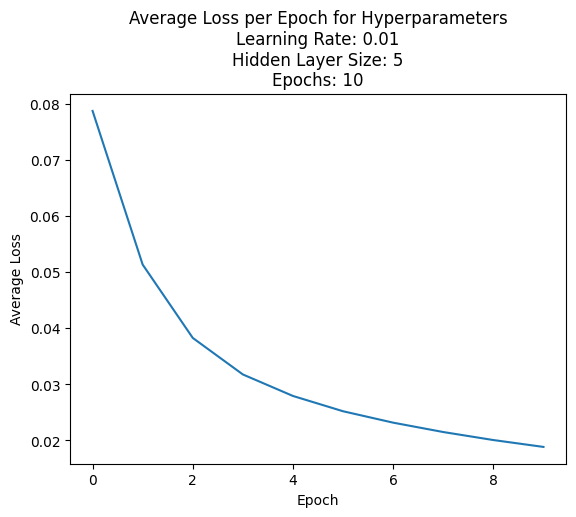

100%|██████████| 1000/1000 [00:14<00:00, 67.70it/s]


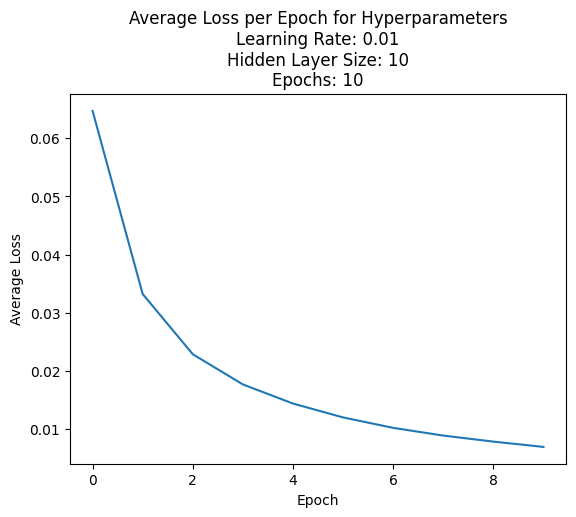

100%|██████████| 1000/1000 [00:41<00:00, 24.00it/s]


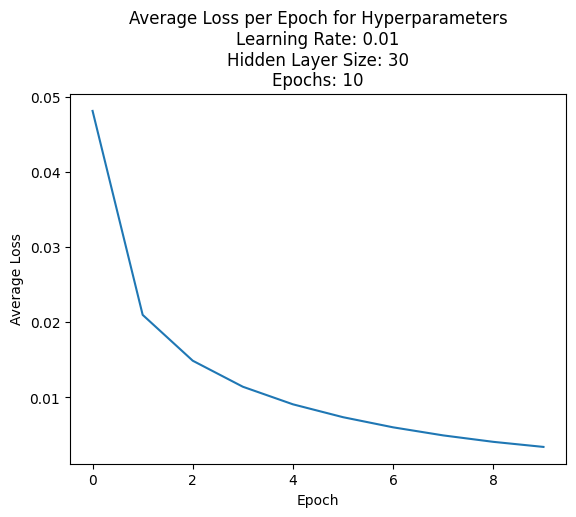

100%|██████████| 1000/1000 [00:10<00:00, 94.47it/s]


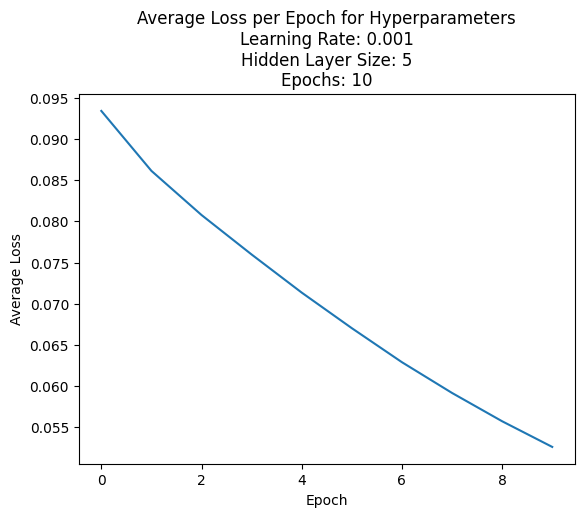

100%|██████████| 1000/1000 [00:16<00:00, 60.87it/s]


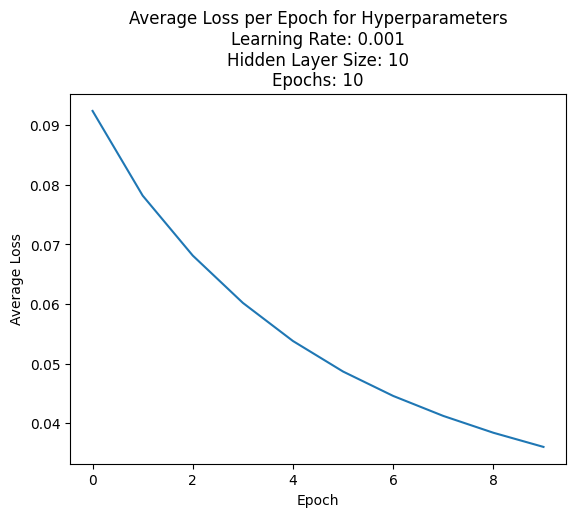

100%|██████████| 1000/1000 [00:36<00:00, 27.44it/s]


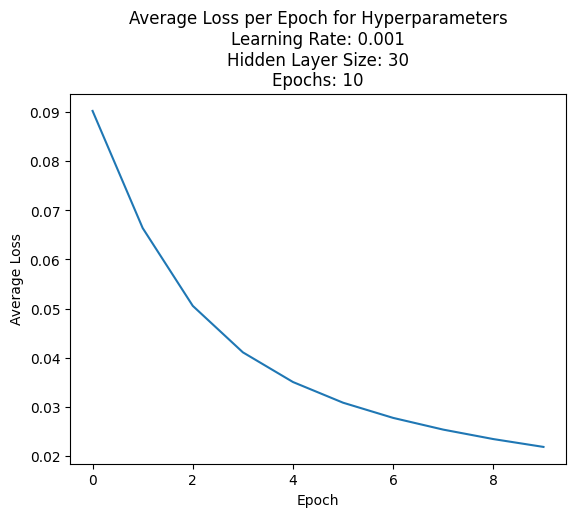

100%|██████████| 1000/1000 [00:07<00:00, 132.69it/s]


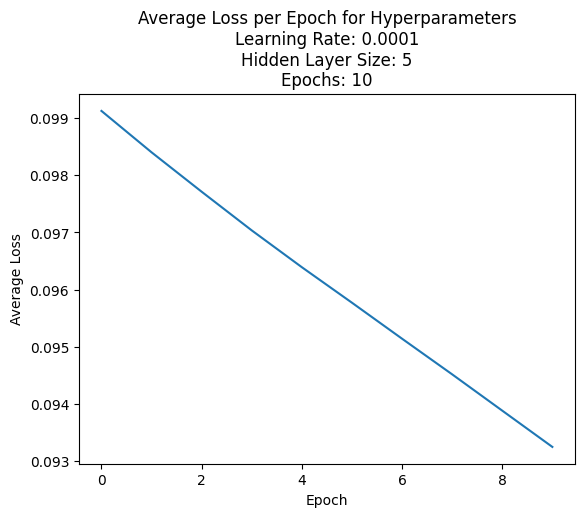

100%|██████████| 1000/1000 [00:09<00:00, 101.86it/s]


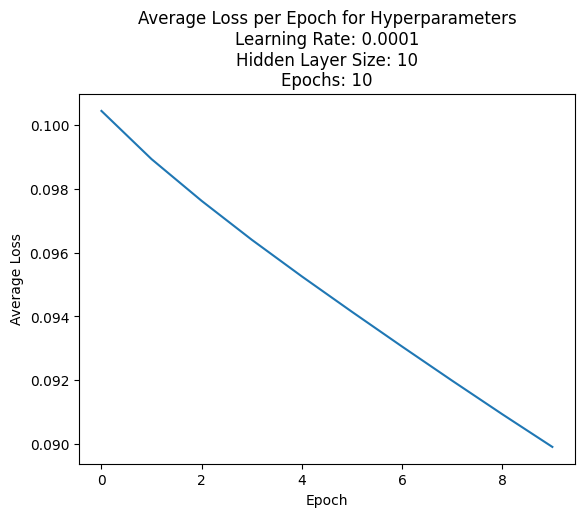

100%|██████████| 1000/1000 [00:26<00:00, 38.45it/s]


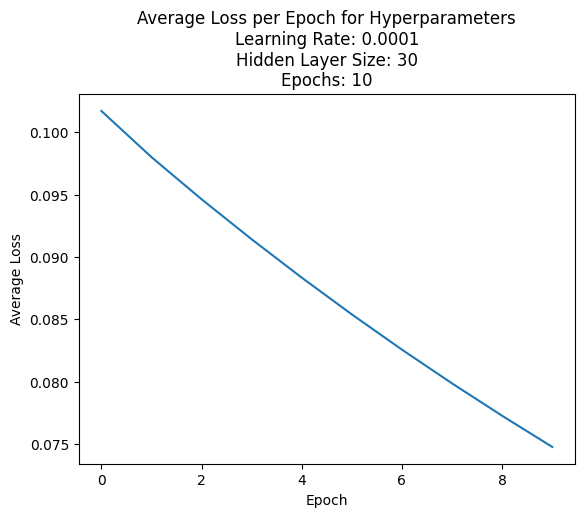

In [16]:
raw_train_data, raw_test_data = load_data()
train_labels, train_images = prepare_data(raw_train_data)

all_hyperparameter_combinations = [
    Hyperparameters(learning_rate, hidden_layer_size, 10) for learning_rate in (0.01, 0.001, 0.0001) for hidden_layer_size in (5, 10, 30)
]

for hyperparameters in all_hyperparameter_combinations:
    mlp = MLP(784, hyperparameters.hidden_layer_size, 10)

    average_losses_per_epoch = egit(
        mlp,
        train_images,
        train_labels,
        epochs=hyperparameters.epochs,
        learning_rate=hyperparameters.learning_rate
    )

    results: Result = Result(
        hyperparameters,
        average_losses_per_epoch
    )

    results.generate_plot()

In [6]:
raw_train_data, raw_test_data = load_data()
train_labels, train_images = prepare_data(raw_train_data)

mlp = MLP(784, 30, 10)

egit(
    mlp,
    train_images,
    train_labels,
    epochs=1,
    learning_rate=0.01
)

test_labels, test_images = prepare_data(raw_test_data)

correct_predictions = 0

for i in range(test_images.boyut()[0]):
    if i == 1000:
        break

    print(i, end=" ")

    sample = test_images[i]
    target_label = test_labels[i].listeye()

    target_expected_list = [0] * 10
    target_expected_list[target_label] = 1

    target_expected_gergen = gergen(target_expected_list).boyutlandir((10,))

    predicted = mlp.ileri(sample)

    if predicted.duzlestir().index(max(predicted.duzlestir())) == target_label:
        print('Correct prediction')
        correct_predictions += 1

    else:
        print('Incorrect prediction')

100%|██████████| 20000/20000 [10:48<00:00, 30.86it/s]


0 Correct prediction
1 Correct prediction
2 Correct prediction
3 Correct prediction
4 Correct prediction
5 Correct prediction
6 Correct prediction
7 Correct prediction
8 Incorrect prediction
9 Correct prediction
10 Correct prediction
11 Correct prediction
12 Correct prediction
13 Correct prediction
14 Correct prediction
15 Correct prediction
16 Correct prediction
17 Correct prediction
18 Correct prediction
19 Correct prediction
20 Correct prediction
21 Correct prediction
22 Correct prediction
23 Correct prediction
24 Correct prediction
25 Correct prediction
26 Correct prediction
27 Correct prediction
28 Correct prediction
29 Correct prediction
30 Correct prediction
31 Correct prediction
32 Correct prediction
33 Correct prediction
34 Correct prediction
35 Correct prediction
36 Correct prediction
37 Correct prediction
38 Correct prediction
39 Correct prediction
40 Correct prediction
41 Correct prediction
42 Correct prediction
43 Correct prediction
44 Correct prediction
45 Correct predict

In [10]:
print(str(correct_predictions / 10 )+ '%') # 0.0%

91.5%
